In [12]:
import glob
import os
from typing import Any, Dict, List, Tuple, Union

import torch
import yaml
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder, VisionDataset

from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from custom_vgg import vgg_basic
import torchvision

In [13]:
device = 'cuda'
lr = 0.0001
num_epoch = 60

input_size = 224 #224//2
batch_size = 128
n_worker = 8

In [14]:
import torchvision.transforms.functional as TF
import random

class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

rotation_transform = MyRotationTransform(angles=[0, 180, 90, 270])

In [15]:
normalize = transforms.Normalize(mean= [0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225])

train_dataset = ImageFolder(
    "/opt/ml/data/train", transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.RandomCrop(input_size),
        transforms.RandomHorizontalFlip(),
        MyRotationTransform(angles=[0, 180, 90, 270]),
        transforms.ToTensor(),
        normalize,
    ]))

val_dataset = ImageFolder("/opt/ml/data/val", transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.Resize(int(input_size/0.875)),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        normalize,
    ]))

In [16]:
from torch.utils.data.sampler import WeightedRandomSampler

sample_freq = [1169, 4826, 1020, 2655, 4879, 1092] #[0] * len(train_dataset.classes) #df_ff.gender.value_counts().sort_index().to_numpy()
sample_weight = np.concatenate([[1/f]*f for f in sample_freq])
sample_weight = torch.from_numpy(sample_weight)
sampler = WeightedRandomSampler(sample_weight.type('torch.DoubleTensor'), len(sample_weight)//2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


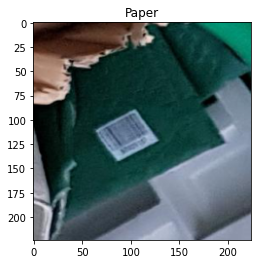

In [17]:
idx = np.random.randint(0, len(train_dataset))
img, label = train_dataset[idx]
img = img.permute(1,2,0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
plt.imshow(img)
plt.title(train_dataset.classes[label])
plt.show()

In [18]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, drop_last=True, sampler = sampler,
    num_workers=n_worker)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, shuffle=False,
    num_workers=n_worker)

dataloaders = { 'train' : train_loader, 'valid' : val_loader}

In [20]:
model = torchvision.models.resnet50(pretrained=True)
#model.load_state_dict(torch.load('/opt/ml/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth'))
model.fc = torch.nn.Linear(2048, 6)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler =   optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose=True, patience=5) # optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=0.000001)#

In [22]:
from trainer import Trainer

trainer = Trainer('/opt/ml/code/save', seed=42)

In [23]:
trainer.train(model, dataloaders, criterion, optimizer, lr_scheduler, num_epoch, 10, 'resnet50')

Epoch 1/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 1 Loss: 0.8091 Acc: 0.7157 F1: 0.7148


100%|██████████| 41/41 [00:15<00:00,  2.64it/s]


valid Epoch: 1 Loss: 0.7463 Acc: 0.7444 F1: 0.7212

Epoch 2/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.13it/s]


train Epoch: 2 Loss: 0.5047 Acc: 0.8261 F1: 0.8255


100%|██████████| 41/41 [00:15<00:00,  2.59it/s]


valid Epoch: 2 Loss: 0.6640 Acc: 0.7747 F1: 0.7405

Epoch 3/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 3 Loss: 0.4248 Acc: 0.8553 F1: 0.8546


100%|██████████| 41/41 [00:15<00:00,  2.63it/s]


valid Epoch: 3 Loss: 0.5505 Acc: 0.8083 F1: 0.7884

Epoch 4/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.13it/s]


train Epoch: 4 Loss: 0.3851 Acc: 0.8682 F1: 0.8676


100%|██████████| 41/41 [00:15<00:00,  2.57it/s]


valid Epoch: 4 Loss: 0.6112 Acc: 0.7924 F1: 0.7619

Epoch 5/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 5 Loss: 0.3495 Acc: 0.8760 F1: 0.8763


100%|██████████| 41/41 [00:15<00:00,  2.63it/s]


valid Epoch: 5 Loss: 0.5808 Acc: 0.8006 F1: 0.7668

Epoch 6/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.14it/s]


train Epoch: 6 Loss: 0.2923 Acc: 0.8989 F1: 0.8992


100%|██████████| 41/41 [00:15<00:00,  2.56it/s]


valid Epoch: 6 Loss: 0.5764 Acc: 0.8114 F1: 0.7825

Epoch 7/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 7 Loss: 0.2654 Acc: 0.9097 F1: 0.9092


100%|██████████| 41/41 [00:15<00:00,  2.59it/s]


valid Epoch: 7 Loss: 0.5950 Acc: 0.8068 F1: 0.7747

Epoch 8/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 8 Loss: 0.2500 Acc: 0.9156 F1: 0.9158


100%|██████████| 41/41 [00:15<00:00,  2.60it/s]


valid Epoch: 8 Loss: 0.5986 Acc: 0.8021 F1: 0.7808

Epoch 9/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.16it/s]


train Epoch: 9 Loss: 0.2459 Acc: 0.9170 F1: 0.9168


100%|██████████| 41/41 [00:15<00:00,  2.60it/s]


valid Epoch: 9 Loss: 0.5830 Acc: 0.8129 F1: 0.7856
Epoch     9: reducing learning rate of group 0 to 1.0000e-05.

Epoch 10/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.11it/s]


train Epoch: 10 Loss: 0.1876 Acc: 0.9346 F1: 0.9339


100%|██████████| 41/41 [00:15<00:00,  2.61it/s]


valid Epoch: 10 Loss: 0.5003 Acc: 0.8315 F1: 0.8063

Epoch 11/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.15it/s]


train Epoch: 11 Loss: 0.1677 Acc: 0.9442 F1: 0.9437


100%|██████████| 41/41 [00:16<00:00,  2.55it/s]


valid Epoch: 11 Loss: 0.4910 Acc: 0.8363 F1: 0.8139

Epoch 12/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.13it/s]


train Epoch: 12 Loss: 0.1478 Acc: 0.9488 F1: 0.9483


100%|██████████| 41/41 [00:15<00:00,  2.57it/s]


valid Epoch: 12 Loss: 0.4951 Acc: 0.8336 F1: 0.8102

Epoch 13/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.15it/s]


train Epoch: 13 Loss: 0.1411 Acc: 0.9557 F1: 0.9554


100%|██████████| 41/41 [00:15<00:00,  2.57it/s]


valid Epoch: 13 Loss: 0.4895 Acc: 0.8424 F1: 0.8209

Epoch 14/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.14it/s]


train Epoch: 14 Loss: 0.1268 Acc: 0.9585 F1: 0.9582


100%|██████████| 41/41 [00:15<00:00,  2.61it/s]


valid Epoch: 14 Loss: 0.4868 Acc: 0.8461 F1: 0.8248

Epoch 15/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 15 Loss: 0.1224 Acc: 0.9599 F1: 0.9598


100%|██████████| 41/41 [00:15<00:00,  2.60it/s]


valid Epoch: 15 Loss: 0.4872 Acc: 0.8440 F1: 0.8246

Epoch 16/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.11it/s]


train Epoch: 16 Loss: 0.1183 Acc: 0.9640 F1: 0.9636


100%|██████████| 41/41 [00:15<00:00,  2.59it/s]


valid Epoch: 16 Loss: 0.4857 Acc: 0.8440 F1: 0.8236

Epoch 17/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 17 Loss: 0.1178 Acc: 0.9612 F1: 0.9613


100%|██████████| 41/41 [00:15<00:00,  2.59it/s]


valid Epoch: 17 Loss: 0.4854 Acc: 0.8440 F1: 0.8233

Epoch 18/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 18 Loss: 0.1075 Acc: 0.9663 F1: 0.9663


100%|██████████| 41/41 [00:15<00:00,  2.62it/s]


valid Epoch: 18 Loss: 0.4917 Acc: 0.8442 F1: 0.8252

Epoch 19/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.13it/s]


train Epoch: 19 Loss: 0.0953 Acc: 0.9726 F1: 0.9728


100%|██████████| 41/41 [00:15<00:00,  2.61it/s]


valid Epoch: 19 Loss: 0.4932 Acc: 0.8463 F1: 0.8271

Epoch 20/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.14it/s]


train Epoch: 20 Loss: 0.1020 Acc: 0.9676 F1: 0.9678


100%|██████████| 41/41 [00:16<00:00,  2.54it/s]


valid Epoch: 20 Loss: 0.4902 Acc: 0.8455 F1: 0.8256

Epoch 21/60
----------


100%|██████████| 61/61 [00:29<00:00,  2.10it/s]


train Epoch: 21 Loss: 0.1065 Acc: 0.9682 F1: 0.9678


100%|██████████| 41/41 [00:15<00:00,  2.62it/s]


valid Epoch: 21 Loss: 0.5004 Acc: 0.8426 F1: 0.8240

Epoch 22/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.13it/s]


train Epoch: 22 Loss: 0.0875 Acc: 0.9717 F1: 0.9711


100%|██████████| 41/41 [00:15<00:00,  2.59it/s]


valid Epoch: 22 Loss: 0.4969 Acc: 0.8482 F1: 0.8270

Epoch 23/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 23 Loss: 0.0859 Acc: 0.9754 F1: 0.9754


100%|██████████| 41/41 [00:15<00:00,  2.57it/s]


valid Epoch: 23 Loss: 0.5050 Acc: 0.8446 F1: 0.8262

Epoch 24/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 24 Loss: 0.0815 Acc: 0.9750 F1: 0.9752


100%|██████████| 41/41 [00:15<00:00,  2.58it/s]


valid Epoch: 24 Loss: 0.5016 Acc: 0.8486 F1: 0.8293

Epoch 25/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.11it/s]


train Epoch: 25 Loss: 0.0808 Acc: 0.9761 F1: 0.9758


100%|██████████| 41/41 [00:15<00:00,  2.63it/s]


valid Epoch: 25 Loss: 0.5038 Acc: 0.8449 F1: 0.8254

Epoch 26/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 26 Loss: 0.0789 Acc: 0.9762 F1: 0.9761


100%|██████████| 41/41 [00:15<00:00,  2.61it/s]


valid Epoch: 26 Loss: 0.5044 Acc: 0.8488 F1: 0.8293

Epoch 27/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.15it/s]


train Epoch: 27 Loss: 0.0676 Acc: 0.9805 F1: 0.9803


100%|██████████| 41/41 [00:15<00:00,  2.60it/s]


valid Epoch: 27 Loss: 0.5076 Acc: 0.8495 F1: 0.8304

Epoch 28/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 28 Loss: 0.0632 Acc: 0.9826 F1: 0.9825


100%|██████████| 41/41 [00:16<00:00,  2.55it/s]


valid Epoch: 28 Loss: 0.5163 Acc: 0.8482 F1: 0.8281

Epoch 29/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.11it/s]


train Epoch: 29 Loss: 0.0612 Acc: 0.9830 F1: 0.9827


100%|██████████| 41/41 [00:15<00:00,  2.59it/s]


valid Epoch: 29 Loss: 0.5189 Acc: 0.8484 F1: 0.8282

Epoch 30/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.13it/s]


train Epoch: 30 Loss: 0.0590 Acc: 0.9830 F1: 0.9830


100%|██████████| 41/41 [00:15<00:00,  2.63it/s]


valid Epoch: 30 Loss: 0.5261 Acc: 0.8492 F1: 0.8296

Epoch 31/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.13it/s]


train Epoch: 31 Loss: 0.0564 Acc: 0.9828 F1: 0.9828


100%|██████████| 41/41 [00:16<00:00,  2.55it/s]


valid Epoch: 31 Loss: 0.5293 Acc: 0.8474 F1: 0.8280

Epoch 32/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


train Epoch: 32 Loss: 0.0571 Acc: 0.9841 F1: 0.9842


100%|██████████| 41/41 [00:15<00:00,  2.58it/s]


valid Epoch: 32 Loss: 0.5350 Acc: 0.8430 F1: 0.8217

Epoch 33/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.16it/s]


train Epoch: 33 Loss: 0.0582 Acc: 0.9836 F1: 0.9836


100%|██████████| 41/41 [00:15<00:00,  2.61it/s]


valid Epoch: 33 Loss: 0.5332 Acc: 0.8451 F1: 0.8237
Epoch    33: reducing learning rate of group 0 to 1.0000e-06.

Epoch 34/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.16it/s]


train Epoch: 34 Loss: 0.0539 Acc: 0.9848 F1: 0.9849


100%|██████████| 41/41 [00:15<00:00,  2.57it/s]


valid Epoch: 34 Loss: 0.5308 Acc: 0.8463 F1: 0.8253

Epoch 35/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.14it/s]


train Epoch: 35 Loss: 0.0549 Acc: 0.9851 F1: 0.9852


100%|██████████| 41/41 [00:15<00:00,  2.63it/s]


valid Epoch: 35 Loss: 0.5297 Acc: 0.8484 F1: 0.8276

Epoch 36/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.15it/s]


train Epoch: 36 Loss: 0.0553 Acc: 0.9849 F1: 0.9849


100%|██████████| 41/41 [00:15<00:00,  2.61it/s]


valid Epoch: 36 Loss: 0.5320 Acc: 0.8490 F1: 0.8279

Epoch 37/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.13it/s]


train Epoch: 37 Loss: 0.0595 Acc: 0.9834 F1: 0.9832


100%|██████████| 41/41 [00:15<00:00,  2.57it/s]


valid Epoch: 37 Loss: 0.5347 Acc: 0.8457 F1: 0.8247

Epoch 38/60
----------


100%|██████████| 61/61 [00:28<00:00,  2.11it/s]


train Epoch: 38 Loss: 0.0523 Acc: 0.9855 F1: 0.9856


100%|██████████| 41/41 [00:15<00:00,  2.61it/s]

valid Epoch: 38 Loss: 0.5333 Acc: 0.8451 F1: 0.8253

Training complete!
Best f1 score 0.8304 at epoch 27

